In [24]:
import os
import time

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from DataBase import DataBase, DataBase_pkl,DataBase_pkl_2D
import networks
from model import FullNet, ConvNet
from get_freqs import findFreq
import losses
import torch.nn.functional as F

import scipy.signal as signal
import numpy as np
import seaborn as sb
from functools import reduce
import scipy.io as spio
from torch.autograd import Variable

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from multiscale_resnet import MSResNet,MSResNet2,MSResNet3,ResNet,MSResNet4

In [64]:
testing = DataBase_pkl('./','test', SNR = 0.0,number_of_locations =2)
test_dataloader = DataLoader(testing, batch_size=100)#, num_workers=4)

In [106]:
inputs,spect,targets, targets_ps, signal_proxy ,signal_class = next(iter(test_dataloader))

In [107]:
spio.savemat('test.mat',dict(signals = inputs.numpy(),targets = targets.numpy()))

In [109]:
inputs = torch.cat((inputs,spect), dim=1)

In [ ]:
targets = targets[:,:,0]
targets,_ = targets.sort()

In [111]:
strcut = spio.loadmat('./psnet3')

In [112]:
T1 = np.unique(struct['lookuptable'][:,0])
T2 = np.unique(struct['lookuptable'][:,0])

In [113]:
def get_spectrum(signal,npoints):
    fft = np.fft.fft(signal, norm='ortho', n=(npoints))
    spectrum = fft.real**2+fft.imag**2
    return spectrum
def calc_err(esti,GT):
    return abs(np.min(esti,1)-np.min(GT,1))/abs(np.min(GT,1)) + abs(np.max(esti,1)-np.max(GT,1))/abs(np.max(GT,1))
    #return np.minimum(abs(np.min(esti,1)-np.min(GT,1))/np.min(GT,1) , abs(np.max(esti,1)-np.max(GT,1))/np.max(GT,1))

In [481]:
# Load model
target_dim = 2
SNR = 0.0
model_name = '512_2_model_4_1000.0_model'#'306_4_autoencoder20_SNR_0.0_model'
model = ResNet(input_channel=1, num_classes=target_dim)

model = nn.DataParallel(model)
# Load model 
checkpoint = torch.load('saved_model/'+model_name+'_data.pth.tar',map_location=lambda storage, loc: storage)
print("model loaded")
print("model epoch {}".format(checkpoint['epoch']))
print("model Validation Err {}".format(checkpoint['Err']))
# restores the model and optimizer state_dicts
model.load_state_dict(checkpoint['state_dict'])
model.eval()

model loaded
model epoch 796
model Validation Err 0.10627603503635952


DataParallel(
  (module): ResNet(
    (lin_in): Linear(in_features=512, out_features=1024, bias=True)
    (bn_in): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer5x5_1): Sequential(
      (0): BasicBlock3x3(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv1d(64

In [97]:
out.shape

torch.Size([100, 2])

In [482]:
out = model(inputs.float())
esti = out.detach().numpy()*(max(T1) - min(T1)) + min(T1)
GT = targets.numpy()*(max(T1) - min(T1)) + min(T1)
err_T1 = calc_err(esti,GT)

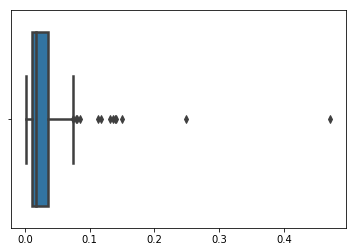

In [120]:
sb.boxplot(err_T1,linewidth=2.5)

In [484]:
np.std(err_T1)

0.051057793

In [121]:
def calc_err_(esti,GT):
    return (esti-GT)/GT

In [142]:
err_T11 = []
err_T12 = []
GT_T11 = []
GT_T12 = []
for inputs,spect,targets, targets_ps,_ ,_ in test_dataloader:
    inputs = torch.cat((inputs,spect), dim=1)
    out = model(inputs.float())
    targets = targets[:,:,0]
    targets,_ = targets.sort()
    targets = targets.float()
    err_T11.append(calc_err_(out[:,0]*(max(T1) - min(T1)) + min(T1),targets[:,0]*(max(T1) - min(T1)) + min(T1)))
    err_T12.append(calc_err_(out[:,1]*(max(T1) - min(T1)) + min(T1),targets[:,1]*(max(T1) - min(T1)) + min(T1)))
    GT_T11.append(targets[:,0]*(max(T1) - min(T1)) + min(T1))
    GT_T12.append(targets[:,1]*(max(T1) - min(T1)) + min(T1))

In [143]:
err_T11 = torch.cat(err_T11,0)
err_T12 = torch.cat(err_T12,0)

In [144]:
GT_T11 = torch.cat(GT_T11,0)
GT_T12 = torch.cat(GT_T12,0)

In [148]:
len(GT_T11)

3000

In [158]:
err_T11.detach().numpy()

array([ 0.02339031,  0.00680149, -0.00333209, ..., -0.00277841,
        0.00970638, -0.00698238], dtype=float32)

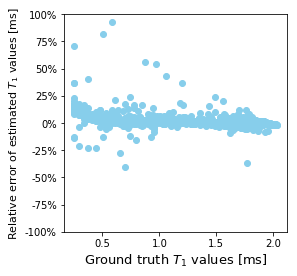

In [236]:
from matplotlib.ticker import PercentFormatter
plt.plot(GT_T11.detach().numpy(),err_T11.detach().numpy(),'skyblue',marker='o',linestyle="None")
#plt.xlim([0.15,2.1])
plt.ylim([-1,1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=13)
plt.ylabel(r'Relative error of estimated $T_1$ values [ms]',fontsize=11)
fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.savefig('T11_heatmap.png',bbox_inches='tight')

In [465]:
np.mean(err_T11.detach().numpy())

0.00879191

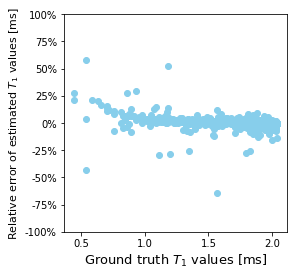

In [237]:
from matplotlib.ticker import PercentFormatter
plt.plot(GT_T12.detach().numpy(),err_T12.detach().numpy(),'skyblue',marker='o',linestyle="None")
#plt.xlim([0.15,2.1])
plt.ylim([-1,1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=13)
plt.ylabel(r'Relative error of estimated $T_1$ values [ms]',fontsize=11)
fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.savefig('T12_heatmap.png',bbox_inches='tight')

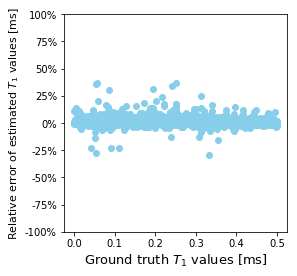

In [466]:
plt.plot(a_,b_,'skyblue',marker='o',linestyle="None")
#plt.xlim([0.15,2.1])
plt.ylim([-1,1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=13)
plt.ylabel(r'Relative error of estimated $T_1$ values [ms]',fontsize=11)
fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.savefig('T11_regression.png',bbox_inches='tight')

In [463]:
np.mean(b_)

0.00746812864489141

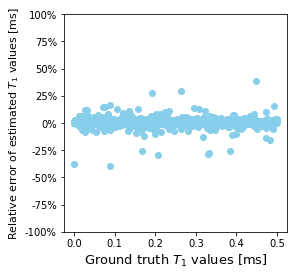

In [467]:
plt.plot(c_,d_,'skyblue',marker='o',linestyle="None")
#plt.xlim([0.15,2.1])
plt.ylim([-1,1])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=13)
plt.ylabel(r'Relative error of estimated $T_1$ values [ms]',fontsize=11)
fig = plt.gcf()
fig.set_size_inches(4, 4)
plt.savefig('T12_regression.png',bbox_inches='tight')

In [464]:
np.mean(d_)

0.0034365194061145915

In [276]:
outputs_all = []
targets_all = []
for inputs,spect,targets, targets_ps,_ ,_ in test_dataloader:
    inputs = torch.cat((inputs,spect), dim=1)
    out = model(inputs.float())
    targets = targets[:,:,0]
    targets,_ = targets.sort()
    targets = targets.float()
    
    outputs_all.append(out)
    targets_all.append(targets)
outputs_all = torch.cat(outputs_all)
targets_all = torch.cat(targets_all)
outputs_all_flatted = outputs_all.detach().numpy()#.flatten()
targets_all_flatted = targets_all.detach().numpy()#.flatten()

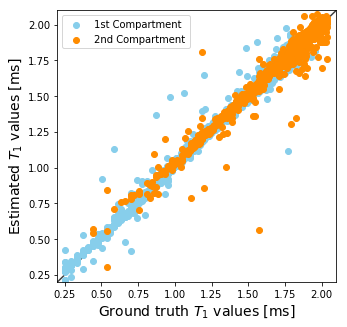

In [457]:
c = ['skyblue','darkorange' ]
legends = ['1st Compartment', '2nd Compartment']
fig, ax = plt.subplots()
for i in range(outputs_all_flatted.shape[1]):
    ax.scatter(targets_all_flatted[:,i]*(max(T1) - min(T1)) + min(T1), outputs_all_flatted[:,i]*(max(T1) - min(T1)) + min(T1),color =c[i], label = legends[i])
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=14)
plt.ylabel(r'Estimated $T_1$ values [ms]',fontsize=14) 
ax.set_xlim([0.2,2.1])
ax.set_ylim([0.2,2.1])
plt.legend()
#fig = plt.gcf()
fig.set_size_inches(5, 5)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.savefig('esti_gt_heatmap.png',bbox_inches='tight')

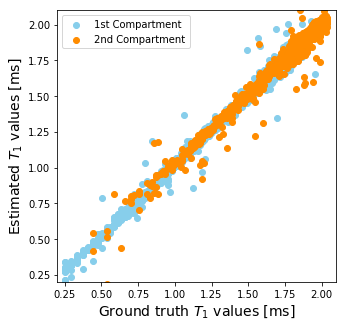

In [451]:
co = ['skyblue','darkorange' ]
legends = ['1st Compartment', '2nd Compartment']
dd = [e,f]
for i in range(2):
    plt.scatter(targets_all_flatted[:,i]*(max(T1) - min(T1)) + min(T1), dd[i]*(max(T1) - min(T1)) + min(T1),color =c[i], label = legends[i])
plt.xlabel(r'Ground truth $T_1$ values [ms]',fontsize=14)
plt.ylabel(r'Estimated $T_1$ values [ms]',fontsize=14) 
plt.xlim([0.2,2.1])
plt.ylim([0.2,2.1])
plt.legend()
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.savefig('esti_gt_regression.png',bbox_inches='tight')